In [1]:
import numpy as np          # fundamental package for scientific computing
import glob                 # return all file paths that match a specific pattern
import matplotlib.pyplot as plt 
import os                   # to interact with the operating system
import csv                  # to save indices

In [2]:
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/')+'timeseries/*time_series.npy')

hist_end = (2014-1850)*12
time_annual = np.arange(1850,1850+(hist_end/12))

In [3]:
raw_files

['/home/innag3580/phase1_CONDA/timeseries/OSNAPeast_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/OSNAPwest_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/bsf_min_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/maxi_dens_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/maxi_dept_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/rapi_dens_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/rapi_dept_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/spgy_dens_time_series.npy',
 '/home/innag3580/phase1_CONDA/timeseries/spgy_dept_time_series.npy']

In [4]:
def find_corresponding_file_name(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  
            break
    return vvel_filename

# find the corresponding number in the bsf list
def find_corresponding_bsf_number(vvel_number_to_find):
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order_bsf.txt'), 'r') as file:
        bsf_list = file.readlines()
    with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
        vvel_list = file.readlines()
    vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
    bsf_dict = {filename.split()[1]: int(filename.split()[0]) for filename in bsf_list}
    vvel_filename = None
    for filename in vvel_list:
        if vvel_dict[filename.split()[1]] == vvel_number_to_find:
            vvel_filename = filename.split()[1]  # Extract the filename part
            break
    bsf_filename = vvel_filename.replace("vvel", "bsf")
    return bsf_dict[bsf_filename], bsf_filename

# Perform change point analysis on SPG dens

In [5]:
h = 7  # spgy_dens_time_series

# Set threshold factor
threshold_multiple = 1

signals = np.load(raw_files[h])
signals = signals[:hist_end]
num_time_series = signals.shape[1]

# Set window size (period 1), duration threshold (period 2)
window_size = 40
duration_threshold = 20
period = window_size + duration_threshold

criteria_indices_dict = {}
for i in range(num_time_series):
    # compute annual means
    signal = signals[:, i]
    reshaped_data = signal.reshape(-1, 12)
    annual_means = np.mean(reshaped_data, axis=1)

    criteria_indices = []
    for j in range(window_size, len(annual_means) - duration_threshold):

        # Compute mean and std of period 1
        window = annual_means[j - window_size:j]
        std_window = np.std(window)
        avg_window = np.mean(window)

        # compute mean of period 2
        threshold = annual_means[j:j + duration_threshold]
        avg_threshold = np.mean(threshold)

        # Check if the std is above the threshold
        if avg_threshold >= avg_window + (threshold_multiple * std_window):
            condition = "Above"
        elif avg_threshold <= avg_window - (threshold_multiple * std_window):
            condition = "Below"
        else:
            condition = "Within"

        if condition != "Within":
            if len(criteria_indices) == 0:
                criteria_indices.append((j, condition))
            elif j >= criteria_indices[-1][0] + 10:
                criteria_indices.append((j, condition))

    # Save criteria_indices in the dictionary
    criteria_indices_dict[i] = criteria_indices
    

result = []
for index, values in criteria_indices_dict.items():
    if values:
        result.append((index, values))


In [6]:
len(result)

49

# Save change points

In [7]:
with open('1_std_events_dens_spg.csv', 'w', newline='') as csvfile:
    fieldnames = ['Index', 'Values', 'Condition']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for index, values in result:
        for value, condition in values:
            writer.writerow({'Index': index, 'Values': value, 'Condition': condition})

# Plot members with events and indicate criteria

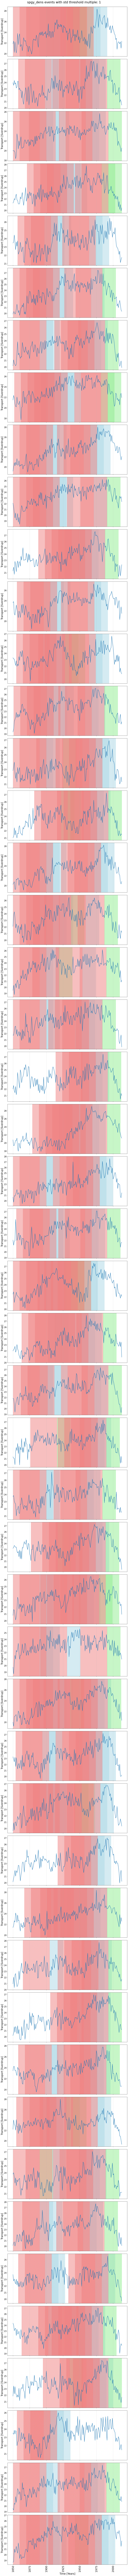

In [16]:
num_subplots = len(result)

fig, axs = plt.subplots(num_subplots, 1, figsize=(14, 6 * num_subplots), sharex=True)
for k, (index, values) in enumerate(result):
    signal = signals[:, index]

    reshaped_data = signal.reshape(-1, 12)
    annual_means = np.mean(reshaped_data, axis=1)
    file_name = find_corresponding_file_name(index)[5:-3]

    axs[k].plot(time_annual, annual_means, label=f'Member {file_name}', linewidth=2)
    for value, condition in values:
        start = value + 1850
        end = value + duration_threshold + 1850
        
        axs[k].axvspan(start - window_size, start, alpha=0.5, color='lightcoral', label=str(window_size)+' years before')
        if condition == "Below":
            axs[k].axvspan(start, end, alpha=0.5, color='lightgreen', label='Below Threshold')
        else:
            axs[k].axvspan(start, end, alpha=0.5, color='lightblue', label='Above Threshold')
        
    #axs[k].legend(fontsize=18, loc='upper left')
    axs[k].set_ylabel('Transport [Sverdrup]', fontsize=20)
    axs[k].yaxis.set_tick_params(labelsize=16)

axs[-1].set_xticks(time_annual[::25])
axs[-1].set_xlabel('Time [Years]', fontsize=20)
axs[-1].set_xticklabels([int(x) for x in time_annual[::25]], fontsize=20, rotation=90)  # Set x-tick labels as integers with fontsize 20 and rotation 90 degrees
for ax in axs:
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)
fig.suptitle(raw_files[h][40:-16]+' events with std threshold multiple: '+str(threshold_multiple), fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'1_std_events.png', bbox_inches='tight')